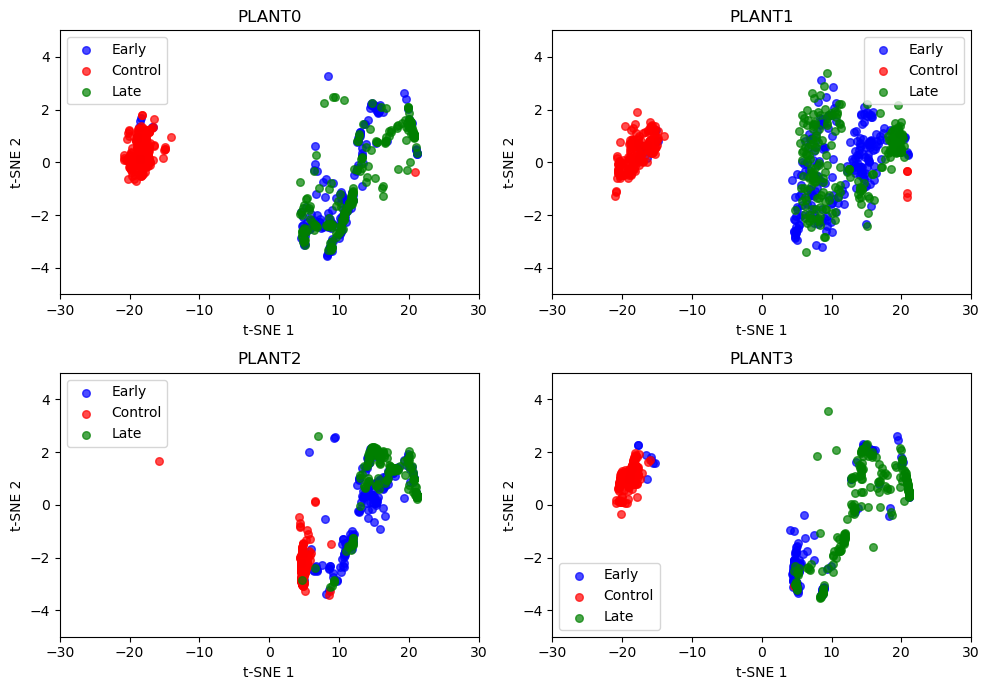

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from openTSNE import TSNE
from sklearn.preprocessing import MinMaxScaler

# --- Configuration ---
base_path = "C:/Users/halhajali/OneDrive - Fondazione Istituto Italiano Tecnologia/Desktop/IIT-UNIBZ/Dataset/Iron-Stress/"
conditions = ['Early', 'Control', 'Late']
plants = ['plant0', 'plant1', 'plant2', 'plant3']
condition_colors = {'Early': 'blue', 'Control': 'red', 'Late': 'green'}
indices = [198,199, 187]
#indices = list(range(200))
# --- Data Loading Function ---
def load_data():
    all_data, all_labels, all_ids = [], [], []
    for condition in conditions:
        for plant in plants:
            path = os.path.join(base_path, condition, plant)
            if not os.path.exists(path):
                continue
            for file in os.listdir(path):
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(path, file), header=None)
                    values = np.array(df).take(indices, axis=0)[:, [3, 4]]
                    values = values.flatten()
                    all_data.append(values)
                    all_labels.append(condition)
                    all_ids.append(plant)
    return np.vstack(all_data), np.array(all_labels), np.array(all_ids)

# --- Load and preprocess data ---
data, labels, plant_ids = load_data()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# --- Split by plant ---
plant_data = {p: scaled_data[plant_ids == p] for p in plants}
plant_labels = {p: labels[plant_ids == p] for p in plants}

# --- Initialize t-SNE ---
tsne = TSNE(
    perplexity=100,
    learning_rate='auto',
    metric='cosine',
    n_jobs=-1,
    random_state=42,
    initialization='pca'
)

# --- Create figure with subplots ---
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
axs = axs.ravel()

# Fit on Plant3 first (reference model)
reference_embedding = tsne.fit(plant_data['plant1'])

for i, plant in enumerate(plants):
    ax = axs[i]
    
    # For Plant3 (already fitted)
    if plant == 'plant1':
        embedding = reference_embedding
    # For other plants (transform)
    else:
        embedding = reference_embedding.transform(plant_data[plant])
    
    # Plot each condition
    for cond in conditions:
        mask = plant_labels[plant] == cond
        ax.scatter(
            embedding[mask, 0],
            embedding[mask, 1],
            s=30,
            alpha=0.7,
            color=condition_colors[cond],
            label=f'{cond}'
        )
    
    ax.set_title(f'{plant.upper()}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_xlim(-30,30 )
    ax.set_ylim(-5,5)
    # if i == 0:  # Only show legend on first subplot
    ax.legend()

plt.tight_layout()
plt.show()